In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

DIR = "/content/drive/MyDrive/ML_project/data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
df.head()

,super_category,category,path
0,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
1,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
2,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
3,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
4,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...


In [3]:
df_sorted = df.groupby(['category']).count().rename(columns={'path':'count'})[['count']].sort_values(by='count', ascending=False)
df_sorted

,count
category,
Plicatura crispa,442
Pluteus cervinus,419
Tricholoma scalpturatum,414
Xerocomellus chrysenteron,406
Mycena galericulata,375
Byssomerulius corium,374
Cylindrobasidium laeve,364
Armillaria lutea,352
Ganoderma pfeifferi,342


In [160]:
# Global parameters
n_classes = 4
samples_per_class = 400
img_size = 224
training_size_ratio = 0.9
dense_layer_1 = 1024
dense_layer_2 = 1024
batch_size = 32             # if None is 32 (default)
learning_rate = 0.001
patience = 10

In [161]:
# Check if a run with these parameters already exists

df_results = pd.read_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv")
df_results = df_results.loc[(df_results["classes"] == n_classes) &
               (df_results["samples"] == samples_per_class) &
               (df_results["image_height"] == img_size) &
               (df_results["image_width"] == img_size) &
               (df_results["training"] == training_size_ratio) &
               (df_results["dense_layer_1"] == dense_layer_1) &
               (df_results["dense_layer_2"] == dense_layer_2) &
               (df_results["batch_size"] == batch_size) &
               (df_results["learning_rate"] == learning_rate) &
               (df_results["patience"] == patience)]
if df_results.shape[0]:
  print("A run with these parameters already exist, results are:")
  print("Epochs:", df_results.iloc[0]['epochs'])
  print("Training time: %ih %im %is" % 
        (df_results.iloc[0]['training_time_hours'], df_results.iloc[0]['training_time_minutes'], df_results.iloc[0]['training_time_seconds']))
  print("Accuracy:", "{:.2f}".format(df_results.iloc[0]['accuracy']*100) + "%")
  print("Loss:", "{:.4f}".format(df_results.iloc[0]['loss']))
else:
  print("A run with these parameters doesn't exists.")

A run with these parameters doesn't exists.


In [162]:
reference = 'category'
#n_classes = df_sorted.shape[0]

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:n_classes].iterrows():
    size = min(samples_per_class, df.loc[df[reference] == i].shape[0])
    training_size = int(size*training_size_ratio)
    tmp_df = df.loc[df[reference] == i].iloc[:training_size]
    tmp_df['training'] = 1
    df1 = df1.append(tmp_df)
    tmp_df = df.loc[df[reference] == i].iloc[training_size:samples_per_class]
    tmp_df['training'] = 0
    df1 = df1.append(tmp_df)
    
df1.head()

,super_category,category,path,training
0,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,1
1,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,1
2,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,1
3,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,1
4,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,1


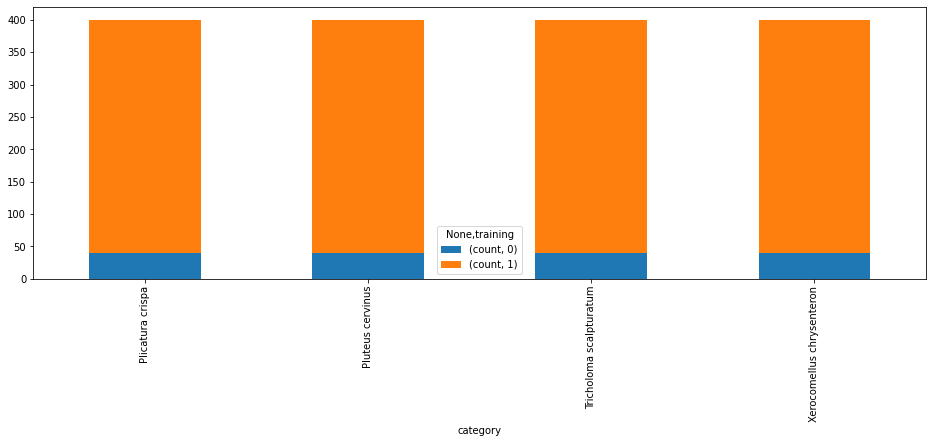

In [163]:
import pandas as pd

df_count = df1.groupby(['category','training']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('training')
df_count.plot(kind='bar', stacked=True, figsize=(16,5))

In [164]:
df_training = df1.loc[df1['training'] == 1]
df_validation = df1.loc[df1['training'] == 0]

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])

Training set: 1440
Validation set: 160


In [165]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
training_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 1440 validated image filenames belonging to 4 classes.


In [166]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(img_size, img_size),
    class_mode='categorical'
)

Found 160 validated image filenames belonging to 4 classes.


In [167]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

print(len(classes))

4


In [168]:
# From https://stackoverflow.com/a/45389215

from tensorflow.keras import applications
from tensorflow.keras.layers import Input

input_tensor = Input(shape=(img_size, img_size, 3))
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

In [169]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

x = Flatten()(x)
x = Dense(dense_layer_1, activation='relu')(x)
x = Dense(dense_layer_2, activation='relu')(x)
x = Dense(len(classes), activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
model = Model(vgg_model.input, x)

for layer in model.layers[:19]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer.name, layer.trainable)

opt = tf.keras.optimizers.RMSprop(learning_rate)
model.compile(loss='categorical_crossentropy',
                     optimizer=opt,
                     metrics=['accuracy'])

input_11 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_10 True
dense_30 True
dense_31 True
dense_32 True


In [170]:
model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [171]:
def elapsed_time(start_time):
    delta = time.time()-start_time
    hours = int(delta/(60*60))
    delta -= hours*(60*60)
    minut = int(delta/60)
    delta -= minut*60
    sec = int(delta)
    return (hours, minut, sec)

In [172]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start_time = time.time()

history = model.fit(train_generator, epochs=100, batch_size=batch_size,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping,checkpoint_callback])

training_time = elapsed_time(start_time)
print("Elapsed time: %ih %im %is" % training_time)

model.load_weights(checkpoint_filepath)
#model.save('/content/drive/MyDrive/ML_project/model.h5')

Epoch 1/100
45/45 [==============================] - 32s 722ms/step - loss: 6.0395 - accuracy: 0.3660 - val_loss: 1.1900 - val_accuracy: 0.5188
Epoch 2/100
45/45 [==============================] - 32s 704ms/step - loss: 1.1676 - accuracy: 0.4708 - val_loss: 0.9728 - val_accuracy: 0.5562
Epoch 3/100
45/45 [==============================] - 31s 695ms/step - loss: 1.0337 - accuracy: 0.5340 - val_loss: 1.0163 - val_accuracy: 0.5938
Epoch 4/100
45/45 [==============================] - 31s 700ms/step - loss: 0.9367 - accuracy: 0.5938 - val_loss: 0.8442 - val_accuracy: 0.6375
Epoch 5/100
45/45 [==============================] - 32s 708ms/step - loss: 0.8261 - accuracy: 0.6500 - val_loss: 0.8177 - val_accuracy: 0.6438
Epoch 6/100
45/45 [==============================] - 32s 708ms/step - loss: 0.8480 - accuracy: 0.6438 - val_loss: 0.7369 - val_accuracy: 0.7063
Epoch 7/100
45/45 [==============================] - 31s 687ms/step - loss: 0.7882 - accuracy: 0.6812 - val_loss: 0.7310 - val_accuracy:

In [ ]:
#import tensorflow as tf

#model = tf.keras.models.load_model('models/vgg16_10_100_128_90.h5')

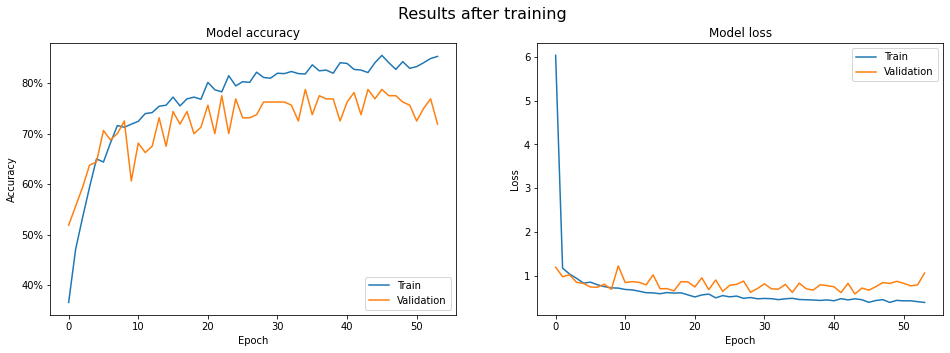

In [173]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [174]:
val_loss, val_acc = model.evaluate(validation_generator)

5/5 [==============================] - 2s 332ms/step - loss: 0.6135 - accuracy: 0.7875


In [175]:
print("Parameters:")
print("Classes:", n_classes)
print("Samples per class:", samples_per_class)
print("Image size:", img_size)
print("Training size:", training_size_ratio)
print("Dense layers:", dense_layer_1, "x", dense_layer_2)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Patience:", patience)

print("\nResults:")
print("Epochs:", len(history.history['accuracy']))
print("Training time: %ih %im %is" % training_time)
print("Accuracy:", "{:.2f}".format(val_acc*100) + "%")
print("Loss:", "{:.4f}".format(val_loss))

Parameters:
Classes: 4
Samples per class: 400
Image size: 224
Training size: 0.9
Dense layers: 1024 x 1024
Batch size: 32
Learning rate: 0.001
Patience: 10

Results:
Epochs: 54
Training time: 0h 28m 54s
Accuracy: 78.75%
Loss: 0.6135


In [176]:
# Store parameters

df_results = pd.read_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv")
row = pd.DataFrame([[n_classes, samples_per_class, img_size, img_size, training_size_ratio,
                    dense_layer_1, dense_layer_2, batch_size, learning_rate,
                    patience, len(history.history['accuracy']), "{:.4f}".format(val_acc), "{:.4f}".format(val_loss),
                    training_time[0], training_time[1], training_time[2]]],
                   columns= ['classes', 'samples', 'image_height', 'image_width', 'training',
                             'dense_layer_1', 'dense_layer_2', 'batch_size',
                             'learning_rate', 'patience', 'epochs', 'accuracy', 'loss',
                             'training_time_hours', 'training_time_minutes', 'training_time_seconds'])
df_results = df_results.append(row)
df_results.to_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv", index=False)

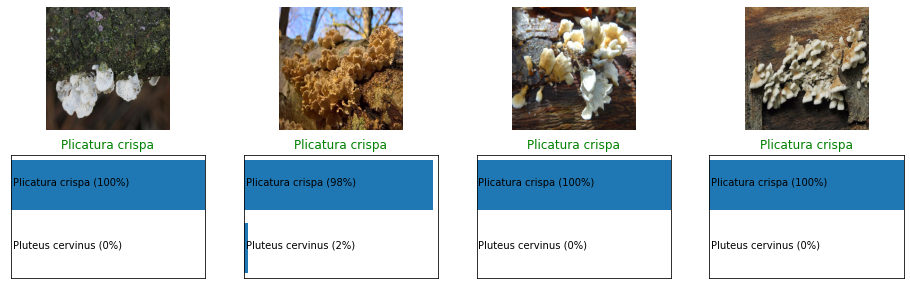

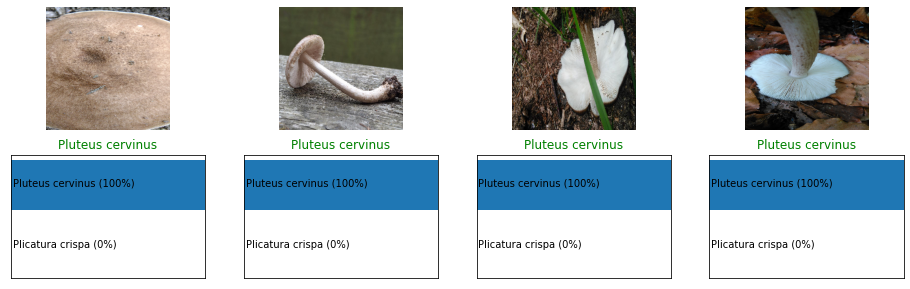

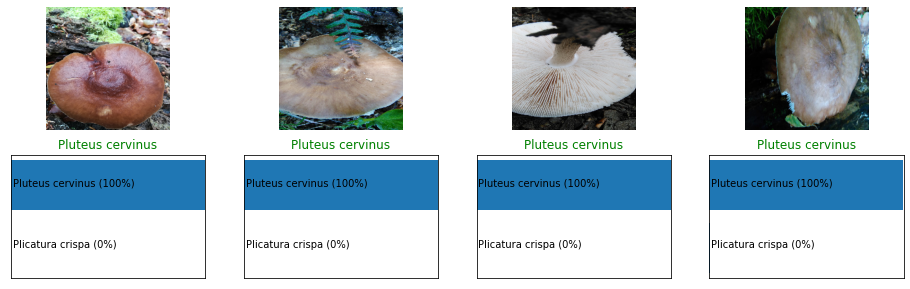

In [137]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import numpy as np

iters = 0
n_predictions = 8
n_cols = 4
    
for i, batch in enumerate(validation_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()